<a href="https://colab.research.google.com/github/IshimotoTakara/probSpace.ukiyo-eAuthorPrediction/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ukiyo-e author prediction

https://prob.space/competitions/ukiyoe-author
の基本情報/Tutorialからスタート

Tutrialでは、DNNのフレームワークであるkerasを用いて簡易なNNを作成している。

Tutrialをベースに改善していくことが本題。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ライブラリのインポート



In [12]:
# データの読み込み
import numpy as np
import os

# プロット
import matplotlib.pyplot as plt

# 前処理
from tensorflow.keras.utils import to_categorical

# 識別
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from sklearn.metrics import log_loss

# 識別の出力
import pandas as pd

## データの読み込み

In [3]:
class UkiyoeDataLoader(object):
    """
    Example
    -------
    >>> ukiyoe_dl = UkiyoeDataLoader()
    >>> datapath = "./data"
    >>> train_imgs, train_lbls, validation_imgs, validation_lbls = ukiyoe_dl.load(datapath)
    """
    def __init__(self, validation_size: float):
        """
        validation_size : float
        [0., 1.]
        ratio of validation data
        """
        self._basename_list = [
        'ukiyoe-train-imgs.npz',\
        'ukiyoe-train-labels.npz'
        ]
        self.validation_size = validation_size

    def load(self, datapath: str, random_seed: int=13) -> np.ndarray:
        filenames_list = self._make_filenames(datapath)
        data_list = [np.load(filename)['arr_0'] for filename in filenames_list]

        all_imgs, all_lbls = data_list

        # shuffle data
        np.random.seed(random_seed)
        perm_idx = np.random.permutation(len(all_imgs))
        all_imgs = all_imgs[perm_idx]
        all_lbls = all_lbls[perm_idx]

        # split train and validation
        validation_num = int(len(all_lbls)*self.validation_size)

        validation_imgs = all_imgs[:validation_num]
        validation_lbls = all_lbls[:validation_num]

        train_imgs = all_imgs[validation_num:]
        train_lbls = all_lbls[validation_num:]

        return train_imgs, train_lbls, validation_imgs, validation_lbls

    def _make_filenames(self, datapath: str) -> list:
        filenames_list = [os.path.join(datapath, basename) for basename in self._basename_list]
        return filenames_list

In [20]:
datapath = "/content/drive/MyDrive/DataScience/Ukiyo-eAuthorPrediction/data/input"
# テストデータの比率を指定(２割のデータをテストデータとする)
validation_size = 0.2
train_imgs, train_lbls, validation_imgs, validation_lbls = UkiyoeDataLoader(validation_size).load(datapath)

## プロット

In [5]:
class RandomPlotter(object):
    def __init__(self):
        self.label_char = ["0", "1", "2", "3",\
                           "4", "5", "6", "7",\
                           "8", "9"]
        plt.rcParams['font.family'] = 'IPAPGothic'

    def _get_unique_labels(self, labels: np.ndarray) -> np.ndarray:
        label_unique = np.sort(np.unique(labels))
        return label_unique

    def _get_random_idx_list(self, labels: np.ndarray) -> list:
        label_unique = self._get_unique_labels(labels)

        random_idx_list = []
        for label in label_unique:
            label_indices = np.where(labels == label)[0]
            random_idx = np.random.choice(label_indices)
            random_idx_list.append(random_idx)

        return random_idx_list

    def plot(self, images: np.ndarray, labels: np.ndarray) -> None:
        """
        Parameters
        ----------
        images : np.ndarray
        train_imgs or validation_imgs

        labels : np.ndarray
        train_lbls or validation_lbls
        """
        random_idx_list = self._get_random_idx_list(labels)

        fig = plt.figure()
        for i, idx in enumerate(random_idx_list):
            ax = fig.add_subplot(2, 5, i+1)
            ax.tick_params(labelbottom=False, bottom=False)
            ax.tick_params(labelleft=False, left=False)
            img = images[idx]
            ax.imshow(img, cmap='gray')
            ax.set_title(self.label_char[i])
        fig.show()

findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


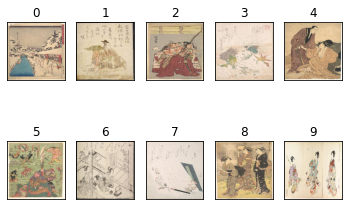

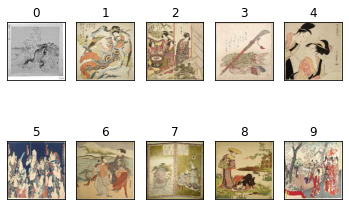

In [6]:
RandomPlotter().plot(train_imgs, train_lbls)
RandomPlotter().plot(validation_imgs, validation_lbls)

## 前処理

ここでは，画像データに対しては，

数値データの型をfloat32へ変更
値を[0, 255]から[0, 1]に標準化を行います．

ラベルデータに対しては，0から9のintで表されたラベルを，one-hot表現に変更を行います．

In [7]:
class Preprocessor(object):
    def transform(self, imgs, lbls=None):
        imgs = self._convert_imgs_dtypes(imgs)
        imgs = self._normalize(imgs)
        if lbls is None:
            return imgs
        lbls = self._to_categorical_labels(lbls)
        return imgs, lbls

    def _convert_imgs_dtypes(self, imgs):
        _imgs = imgs.astype('float32')
        return _imgs

    def _normalize(self, imgs):
        _imgs = imgs / 255.0
        return _imgs

    def _to_categorical_labels(self, lbls):
        label_num = len(np.unique(lbls))
        _lbls = to_categorical(lbls, label_num)
        return _lbls

In [8]:
train_imgs, train_lbls = Preprocessor().transform(train_imgs, train_lbls)

## 識別

DNNのフレームワークであるkerasを用いて簡易なNNを作成して識別

In [9]:
# dataの準備
train_imgs, train_lbls, validation_imgs, validation_lbls = UkiyoeDataLoader(validation_size).load(datapath)

train_imgs, train_lbls = Preprocessor().transform(train_imgs, train_lbls)
validation_imgs, validation_lbls = Preprocessor().transform(validation_imgs, validation_lbls)

f = lambda a: np.histogram(a, bins=128)[0]
train_hists = np.apply_along_axis(f, 1, train_imgs.reshape(len(train_imgs), 224*224, 3))
train_hists = train_hists.reshape(len(train_imgs), -1).astype(np.float)
validation_hists = np.apply_along_axis(f, 1, validation_imgs.reshape(len(validation_imgs), 224*224, 3))
validation_hists = validation_hists.reshape(len(validation_imgs), -1).astype(np.float)

# modelの設定
batch_size = 128
label_num = 10
epochs = 4

# model作成
model = Sequential()

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(label_num, activation='softmax'))

loss = keras.losses.categorical_crossentropy
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# modelを学習する
model.fit(train_hists, train_lbls,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(validation_hists, validation_lbls))

# modelを評価する
train_score = model.evaluate(train_hists, train_lbls)
y_train = model.predict(train_hists)
train_log_loss = log_loss(np.argmax(train_lbls, axis=1), y_train)
validation_score = model.evaluate(validation_hists, validation_lbls)
y_val = model.predict(validation_hists)
validation_log_loss = log_loss(np.argmax(validation_lbls, axis=1), y_val)
print('Train loss :', train_score[0])
print('Train accuracy :', train_score[1])
print('Train log loss :', train_log_loss)
print('validation loss :', validation_score[0])
print('validation accuracy :', validation_score[1])
print('validation log loss :', validation_log_loss)

Epoch 1/4
20/20 [==============================] - 1s 31ms/step - loss: 232.3353 - accuracy: 0.2493 - val_loss: 52.2262 - val_accuracy: 0.3027
Epoch 2/4
20/20 [==============================] - 0s 10ms/step - loss: 34.7444 - accuracy: 0.3522 - val_loss: 19.0886 - val_accuracy: 0.3772
Epoch 3/4
20/20 [==============================] - 0s 9ms/step - loss: 12.6305 - accuracy: 0.4136 - val_loss: 12.3122 - val_accuracy: 0.3724
Epoch 4/4
20/20 [==============================] - 0s 2ms/step - loss: 8.2611 - accuracy: 0.3233
Train loss : 3.8083925247192383
Train accuracy : 0.4166996479034424
Train log loss : 3.658268001663879
validation loss : 8.261082649230957
validation accuracy : 0.32329636812210083
validation log loss : 6.216437144115796


## 識別結果の出力

学習したモデルにテストデータを入力し提出ファイルを作成します.

In [13]:
test_imgs = np.load('/content/drive/MyDrive/DataScience/Ukiyo-eAuthorPrediction/data/ukiyoe-test-imgs.npz')['arr_0']
test_imgs = Preprocessor().transform(test_imgs)
test_hists = np.apply_along_axis(f, 1, test_imgs.reshape(len(test_imgs), 224*224, 3))
test_hists = test_hists.reshape(len(test_imgs), -1).astype(np.float)
predict_lbls = model.predict(test_hists, batch_size=batch_size)
predict_lbls = np.argmax(predict_lbls, axis=1)

In [21]:
df = pd.DataFrame(predict_lbls, columns=['y'])
df.index.name = 'id'
df.index = df.index + 1
df.to_csv('/content/drive/MyDrive/DataScience/Ukiyo-eAuthorPrediction/data/output/predict.csv', float_format='%.5f')

## 誤識別したデータの確認

In [16]:
class MisclassifiedDataPlotter(object):
    """
    このクラスへの入力はpreprocess処理済みのデータを仮定する．
    """
    def __init__(self):
        self.label_char = ["0", "1", "2", "3",\
                           "4", "5", "6", "7",\
                           "8", "9"]
        plt.rcParams['font.family'] = 'IPAPGothic'

    def _convert_onehot2intvec(self, labels):
        labels_int_vec = np.argmax(labels, axis=1)
        return labels_int_vec

    def _get_mixclassified_idx_list(self, labels_intvec, pred_labels_intvec):
        misclassified = labels_intvec != pred_labels_intvec
        mis_idxs_list = np.where(misclassified == True)[0]

        return mis_idxs_list

    def plot(self, images, labels, pred_labels, plot_num: int=5):
        """
        Parameters
        ----------
        images : np.ndarray
        train_imgs or validation_imgs

        labels : np.ndarray
        train_lbls or validation_lbls

        pred_labels : np.ndarray
        predicted labels by trained model

        plot_num : int 
        number of plot images
        """
        labels_intvec = self._convert_onehot2intvec(labels)
        pred_labels_intvec = self._convert_onehot2intvec(pred_labels)

        mis_idxs_list = self._get_mixclassified_idx_list(labels_intvec, pred_labels_intvec)
        random_idx_list = list(np.random.choice(mis_idxs_list, size=plot_num, replace=False))

        fig = plt.figure()
        for i, idx in enumerate(random_idx_list):
            ax = fig.add_subplot(1, plot_num, i+1)
            ax.tick_params(labelbottom=False, bottom=False)
            ax.tick_params(labelleft=False, left=False)
            img = images[idx].reshape((224, 224, 3))
            ax.imshow(img)

            actual_label = self.label_char[labels_intvec[idx]]
            pred_label = self.label_char[pred_labels_intvec[idx]]
            ax.set_title(f"{pred_label} : actual {actual_label}")
        fig.show()

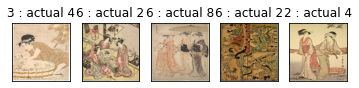

In [17]:
prediction = model.predict(validation_hists) # このmodelは上で作成したkerasのNNです．

mis_plotter = MisclassifiedDataPlotter()
mis_plotter.plot(validation_imgs, validation_lbls, prediction, plot_num=5)